In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
from unicodedata import normalize
import openpyxl
from collections import defaultdict
import matplotlib.pyplot as plt

# 글자체 설정 (한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
test_path = "./data/6_csv/final_data.xlsx"
ref_path = "./data/02_ref_db/ref.xlsx"

test_df = pd.read_excel(test_path,
                        index_col=0)
ref_df = pd.read_excel(ref_path)

In [3]:
# 파일 저장 중 생기는 유니코드 변경 방지 <-- 결측치 제거
test_df["한자"] = test_df["한자"].apply(lambda x : normalize("NFKC", x))
ref_df["한자"] = ref_df["한자"].apply(lambda x : normalize("NFKC", x))

In [4]:
test_df

,출제연도,출제월,과목,지문번호,문제번호,한자
0,2023,11,국어,1,1,持
1,2023,11,국어,1,1,冊
2,2023,11,국어,1,1,理
3,2023,11,국어,1,1,中
4,2023,11,국어,1,1,書
...,...,...,...,...,...,...
50506,2026,9,국어,15,56,反
50507,2026,9,국어,15,56,映
50508,2026,9,국어,15,56,冊
50509,2026,9,국어,15,56,揷


In [5]:
# 참고 데이터가 seaborn 사용 시 텍스트 깨짐 현상 방지
ref_df["등급(기초교육용)"] = ref_df["등급(기초교육용)"].map(
    {"중등" : "middle",
    "고등" : "high",
     "심화" : "others"}
)
# 대한검정회 3급 1000자, 준2급 1500자 / 3급까지 중등(middle), 준2급은 고등(high)로 분류
ref_df["등급(대한검정회)"] = np.select(
    [ref_df["등급(대한검정회)"] >= 3.0,
     ref_df["등급(대한검정회)"] >= 2.5,
     True],
    [3, 2, 1]
)
ref_df["등급(대한검정회)"] = ref_df["등급(대한검정회)"].map(
    {3 : "middle",
    2 : "high",
     1 : "others"}
)
# 대한검정회 4급 1000자, 3급 1800자 / 4급까지 중간(middle), 3급은 고등(high)로 분류
ref_df["등급(한국어문회)"] = np.select(
    [ref_df["등급(한국어문회)"] >= 4.0,
     ref_df["등급(한국어문회)"] >= 3.0,
     True],
    [3, 2, 1]
)
ref_df["등급(한국어문회)"] = ref_df["등급(한국어문회)"].map(
    {3 : "middle",
    2 : "high",
     1 : "others"}
)
# -----------------------------
ref_df

,한자,등급(대한검정회),등급(한국어문회),등급(기초교육용)
0,嫁,others,others,others
1,恪,others,others,others
2,侃,others,others,others
3,玕,others,others,others
4,揀,others,others,others
...,...,...,...,...
2150,兔,others,high,others
2151,姉,others,middle,others
2152,氷,others,middle,middle
2153,強,others,middle,others


#### 주제 : 현재 정의된 상용한자는 국어 중등교육용으로써 적합한가?
* 단순히 나온 횟수를 기반으로, 적절성을 파악한다.
* 서로 각기 다른 지문에 나온 한자 횟수를 기반으로, 적절성을 파악한다.
* 과목별 가중치를 두어, 적절성을 파악한다. (이거... 가중치 조절이 되면 재밌겠는데?)
* 과목별로, 적절성을 파악한다.
* 기초교육용 한자에 해당하는 한자의 비율을 계산하여, 적절성을 파악한다.
* 대한검정회 및 한국어문회 한자 급수에 해당하는 한자의 비율을 계산하여, 적절성을 파악한다.

* 디폴트는 각 교육기관마다의 적합성. (여기서 디폴트란, 모든 항목이 이 과정을 거친다는 것임)
1. 단순횟수 기반
2. 가중치 기반 / 시험 응시율에 따라
3. 가중치 기반 / 평균적인 문제수에 따라
4. 각 과목별 기반
* 참고로, 가중치식은 w_1 (국어 지문과 그의 문제) + w_2 (사탐 과목별 문제) + w_3 (한국사 문제) 가 될 것으로 예상.

In [56]:
# 1. 단순 횟수를 기반
result1_df = pd.DataFrame.merge(
    pd.DataFrame(test_df["한자"].value_counts()),
    ref_df,
    how="left",
    on="한자"
).dropna()
result1_df

,한자,count,등급(대한검정회),등급(한국어문회),등급(기초교육용)
0,對,1006,middle,middle,middle
1,人,785,middle,middle,middle
2,學,588,middle,middle,middle
3,理,573,middle,middle,middle
4,國,563,middle,middle,middle
...,...,...,...,...,...
1224,憐,1,high,high,high
1226,井,1,middle,high,others
1227,屑,1,others,others,others
1229,券,1,high,middle,high


In [111]:
rank_ref_names = ["등급(대한검정회)", "등급(한국어문회)", "등급(기초교육용)"]

y_total = {name:[0, 0, 0] for name in rank_ref_names}

y_cum = {name:[] for name in rank_ref_names}

x = result1_df.index

for i in x:
    for k in y_total.keys():
        if result1_df.loc[i, k] == "middle":
            y_total[k][0] += 1
        elif result1_df.loc[i, k] == "high":
            y_total[k][1] += 1
        else:
            y_total[k][2] += 1
        y_cum[k].append(y_total[k][:])

for k in y_cum.keys():
    y_cum[k] = pd.DataFrame(y_cum[k], columns=["middle", "high", "others"])
y_cum[rank_ref_names[2]]

,middle,high,others
0,1,0,0
1,2,0,0
2,3,0,0
3,4,0,0
4,5,0,0
...,...,...,...
1198,371,408,420
1199,371,408,421
1200,371,408,422
1201,371,409,422


In [109]:
ref_rank = {name:ref_df.groupby(name).count().filter(["한자"])["한자"]
                 for name in rank_ref_names}
rank_total = pd.DataFrame(ref_rank)
rank_total[rank_ref_names[2]]

high       501
middle     378
others    1276
Name: 등급(기초교육용), dtype: int64

In [113]:
for i in rank_ref_names:
    y_cum[i] /= rank_total[i]

y_cum

{'등급(대한검정회)':         middle      high    others
 0     0.001575  0.000000  0.000000
 1     0.003150  0.000000  0.000000
 2     0.004724  0.000000  0.000000
 3     0.006299  0.000000  0.000000
 4     0.007874  0.000000  0.000000
 ...        ...       ...       ...
 1198  0.932283  0.839552  0.305112
 1199  0.933858  0.839552  0.305112
 1200  0.933858  0.839552  0.305911
 1201  0.933858  0.843284  0.305911
 1202  0.933858  0.843284  0.306709
 
 [1203 rows x 3 columns],
 '등급(한국어문회)':         middle      high    others
 0     0.001658  0.000000  0.000000
 1     0.003317  0.000000  0.000000
 2     0.004975  0.000000  0.000000
 3     0.006633  0.000000  0.000000
 4     0.008292  0.000000  0.000000
 ...        ...       ...       ...
 1198  0.980100  0.744235  0.235349
 1199  0.980100  0.746331  0.235349
 1200  0.980100  0.746331  0.236279
 1201  0.981758  0.746331  0.236279
 1202  0.981758  0.746331  0.237209
 
 [1203 rows x 3 columns],
 '등급(기초교육용)':         middle      high    others
 0   

C:\Users\Dell3571\AppData\Local\Temp\ipykernel_14376\257490290.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


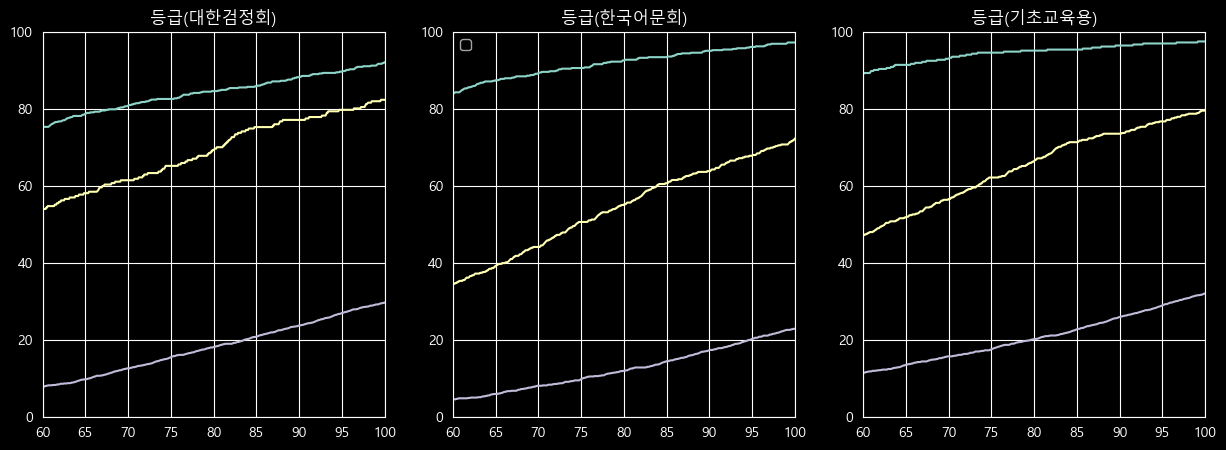

In [126]:
# 기관별 한자분포표
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x = (result1_df.index / len(result1_df.index)) * 100

for i in range(3):
    ay = y_cum[rank_ref_names[i]]["middle"] * 100
    by = y_cum[rank_ref_names[i]]["high"] * 100
    cy = y_cum[rank_ref_names[i]]["others"] * 100

    axes[i].plot(x, ay)
    axes[i].plot(x, by)
    axes[i].plot(x, cy)
    axes[i].set(xlim=(60, 100), ylim=(0, 100))

    axes[i].set_title(rank_ref_names[i])
"""
x = (data.index / len(data.index)) * 100
ay = data["middle"] * 100
by = data["high"] * 100
cy = data["others"] * 100
y = np.vstack([ay, by, cy])

fig, ax = plt.subplots()
ax.plot(x, ay)
ax.plot(x, by)
ax.plot(x, cy)
ax.set(xlim=(50, 100), ylim=(0, 100))
"""
axes[1].legend()
plt.show()

In [ ]:
prop = 65

its = result1_df[result1_df["proportion"] > prop]["proportion"].tolist() # {prop}% 초과의 확률 iterator

check_types = ["등급(대한검정회)", "등급(한국어문회)", "등급(기초교육용)"]
c_type = 2  # 이곳을 바꾸면 비교 대상을 바꿀 수 있습니다.

record = []

for p in its:
    result1_df2_left = pd.merge(result1_df2.iloc[0:int(len(result1_df) * p)],
                                ref_df.value_counts(check_types[c_type]),
                                how="inner",
                                on=check_types[c_type]
                                )
    result1_df_right = (result1_df2_left["count_x"] / result1_df2_left["count_y"] * 100)
    result1_dict = result1_df_right.to_dict()

    for k in result1_dict.keys():
        record.append([p, k, result1_dict[k]])

result1_df3 = pd.DataFrame(record)
result1_df3.columns = ["p", "rank", "rank_p"]
# result1_df3
pd.DataFrame(record)

In [ ]:
# 출제 한자 적중률 비교
g1 = sns.relplot(
    data=result1_df3,
    x="p",
    y="rank_p",
    hue="rank",
    kind="line",
)
g.set(xlim=(70, 100), ylim=(0, 100))
"""
70% : 36.5 / 6.6 / 0.0
82.5% : 54.2 / 11.4 / 1.0
95% : 79.4 / 30.8 / 5.7
"""


In [ ]:
# 상용기관별

## 2. D의 가중치 반영
* 단어가 한번만 나타나도, 그 단어의 뜻을 모른다면 논증을 파악하기가 매우 힘들다.
* 다만 여러번 나타난다고 해서 의미가 달라지지 않는다.
* 정말 드물게 나타나면, 어느 정도 문맥흐름으로 커버가 가능하지만, 다수가 나오면 커버가 힘들다.
* 따라서, log함수를 적용하는 것이 제일 적합하다고 판단.

In [ ]:
# 2. 가중치 기반
result2_df = pd.DataFrame(test_df)
result2_df2 = result2_df.groupby(by=["출제연도", "출제월", "과목", "지문번호", "한자"], as_index=False).sum()
result2_df2["D"] = result2_df2["문제번호"] ** 0.2
result2_df2

In [ ]:
# 2-1. 문제 수에 따른 가중치 기반
"""
평균적으로,
국어 단위 지문 당 약 5.6문제,
사탐 시험 당 20문제,
한국사 시험 20문제로,
이를 통한 가중치 부여.
최종 반영비율(국어 : 사탐 : 한국사) = 1.4 : 5 : 5
"""
result21_df = result2_df2.loc[:, :]
result21_df["D"] = np.select(
    [(result21_df["과목"] == "국어"), (result21_df["과목"] == "한국사"), True],
    [result21_df["D"] * 1.4, result21_df["D"] * 5.0, result21_df["D"] * 5.0]
)
result21_df

In [ ]:
# 한자 그룹화

In [ ]:
# 누적 확률 분포 데이터 추가
result21_df2 = result21_df.loc[:, :]
result21_df2["proportion"] = (result21_df2["D"] / result21_df2["D"].sum()).cumsum() * 100
result21_df2

In [ ]:
result21_df3 = pd.DataFrame.merge(
    result21_df2.filter(["한자", "proportion", "D"]),
    ref_df,
    how="left",
    on="한자"
).dropna()
result21_df3

In [ ]:
prop = 65

its = result21_df3[result21_df3["proportion"] > prop]["proportion"].tolist() # {prop}% 초과의 확률 iterator

check_types = ["등급(대한검정회)", "등급(한국어문회)", "등급(기초교육용)"]
c_type = 2     # 이곳을 바꾸면 비교 대상을 바꿀 수 있습니다.

record = []

for p in its:
    result21_df4_left = pd.merge(result21_df3[result21_df3["proportion"] < p].value_counts(check_types[c_type]),
                                ref_df.value_counts(check_types[c_type]),
                                how="inner",
                                on=check_types[c_type]
                                )
    result21_df4_right = (result21_df4_left["count_y"] / result21_df4_left["count_x"] * 100)
    result21_dict = result21_df4_right.to_dict()

    for k in result21_dict.keys():
        record.append([p, k, result21_dict[k]])

result21_df4 = pd.DataFrame(record)
result21_df4.columns = ["p", "rank", "rank_p"]
result21_df4

In [ ]:
# 출제 한자 적중률 비교
g2 = sns.relplot(
    data=result21_df4,
    x="p",
    y="rank_p",
    hue="rank",
    kind="line",
)
g.set(xlim=(70, 100), ylim=(0, 100))
"""
70% : 36.5 / 6.6 / 0.0
82.5% : 54.2 / 11.4 / 1.0
95% : 79.4 / 30.8 / 5.7
"""

In [ ]:
# 2-2. 시험 응시율에 따른 가중치 기반
"""
한국사와 국어는 필수 과목이므로,
문제 수 비례하는 것이 적절 (4:1)

사탐은 20문제로, 국어와 4:1 관계가 되어야 하지만,
사탐의 응시율은, 2개 모두가 59.3%, 1개만이 0.6%이므로,
반올림하여 60% 정도로 반영.
따라서 4:1 -> 2.4:1

최종 반영비율(국어 : 사탐 : 한국사) = 1 : 2.4 : 4
"""
result22_df = result2_df2
result22_df["D"] = np.select(
    [(result21_df["과목"] == "국어"), (result21_df["과목"] == "한국사"), True],
    [result21_df["D"], result21_df["D"] * 2.4, result21_df["D"] * 4]
)
result22_df

In [ ]:
result22_df2 = result22_df.groupby(["한자"]).sum().filter(["한자","D"])
result22_df2

## 발표를 한다면,
1. 나 "현재 정의된 상용한자는 국어 중등교육용으로써 적합한가?" 로 함.
* 상용한자들을 제시하지만, 실제로 이를 다 아는 사람들은 거의 보기 힘듬.
* 지금 나온 상용한자들, 한문교육 위주 중심으로 나와서, 그런 것으로 '생각'하고 있음.
* 근데 이런 상용한자들은 한문교육엔 적합한지 몰라도, 국어교육에 적합하다는 분석은 없음.
* 그래서 분석하게 됨.

2. 데이터 구하는 과정
* 수능 데이터 뽑음. 그 이유는, 중등교육의 최종보스가 수능이기 때문임.
* 최종보스라고 보는 이유는, 5년간 수능 응시율이 늘어났기 때문임.
* 그리고 수능은 중등교육의 전반적인 과정을 평가하는 것이기 때문에, 이걸 데이터셋으로 뽑는게 타당함.
* 이유는 여기까지고,
* 데이터가 뭐 있는지 소개함.
* 이 데이터가 pdf, txt, 가공, gemini, excel.. 등의 과정을 간단하게, 압축적으로 설명할거임.

3. 분석 과정
* 아까 말한 분석 항목을 기준으로, 분석할거임.
* 이런 분석을 했더니, 이런 결과가 나오는거임.
* 그게 최대 12개 관점(실제로는 4페이지로 압축되지 않을까)로 제시될거임.
* 그래서 데이터를 볼 때, 이러한 관점이 있겠다 제시함 (미정)

끝.